In [117]:
# !pip install pandas-datareader
# !pip install yfinance

In [118]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 삼성 전자 주식 불러오기

In [119]:
df = pd.read_csv('https://raw.githubusercontent.com/zzhining/python_data_basic/main/3%EC%9E%A5/005930.KS.csv', index_col = 0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,55500,56000,55000,55200,52537.17969,12993228
2020-01-03,56000,56600,54900,55500,52822.70703,15422255
2020-01-06,54900,55600,54600,55500,52822.70703,10278951
2020-01-07,55700,56400,55600,55800,53108.23828,10009778
2020-01-08,56200,57400,55900,56800,54059.99219,23501171


In [120]:
X = df.drop(columns = ['Volume'])
y = pd.DataFrame(df['Adj Close'])

In [121]:
def norm_data(data, flag = True):

  mm = MinMaxScaler()
  ss = StandardScaler()

  # flag가 True이면 train
  if flag:
    X_ss = ss.fit_transform(data)

    X_train = X_ss[:300, :]
    X_test = X_ss[300:, :]

    return X_train, X_test, ss

  if not flag:
    y_mm = mm.fit_transform(data)

    y_train = y_mm[:300, :]
    y_test = y_mm[300:, :]

    return y_train, y_test, mm

X_train, X_test, ss = norm_data(X, flag = True)
y_train, y_test, mm = norm_data(y, flag = False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((300, 5), (300, 1), (63, 5), (63, 1))

In [122]:
mm, ss

(MinMaxScaler(), StandardScaler())

In [123]:
# == numpy 상태에서는 학습이 불가능하다 ==
type(X_train)

numpy.ndarray

In [124]:
# == numpy -> Torch로 바꿔주기
'''
시계열 데이터를 다룰 때, 3D tensor형태 (batch_size, sequence_length, input_size)로 사용한다.
'''

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

X_train_tensors_final.shape, y_train.shape


(torch.Size([300, 1, 5]), (300, 1))

### LSTM 모델

In [125]:
class custom_LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(custom_LSTM, self).__init__()

    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1,
                        batch_first = True)

    self.fc1 = nn.Linear(hidden_size, 128)
    self.fc2 = nn.Linear(128, num_classes)

    self.relu = nn.ReLU(inplace = True)

  def forward(self, x):

    '''
    self.num_layers : LSTM layer의 수
    x.size(0) : x의 batch size

    0으로 초기화하는 이유는, 학습을 시작할 때 아무 정보가 없는 상태에서 시작하기 위함이다.
    이를 통해 장기 의존 관계를 학습하고 기억할 수 있다.
    '''
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # hidden state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # cell state

    output, (hn, cn) = self.lstm(x, (h0, c0))

    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [126]:
num_epochs = 3000
learning_rate = 0.0001 #0.001 lr
input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

In [127]:
X_train_tensors_final.shape[1]

1

In [128]:
lstm_fr = custom_LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

cost = torch.nn.MSELoss()
opt = torch.optim.Adam(lstm_fr.parameters(), lr = learning_rate)

### 학습하기

In [129]:
for epoch in range(num_epochs):
  outputs = lstm_fr.forward(X_train_tensors_final.to(device))
  opt.zero_grad()

  loss = cost(outputs, y_train_tensors.to(device))
  loss.backward()
  opt.step()

  if epoch % 100 == 0:
    print(f"Epoch : {epoch}, loss : {loss.item()}")


Epoch : 0, loss : 0.14740152657032013
Epoch : 100, loss : 0.07510148733854294
Epoch : 200, loss : 0.06425787508487701
Epoch : 300, loss : 0.06205159053206444
Epoch : 400, loss : 0.0584854856133461
Epoch : 500, loss : 0.05135652422904968
Epoch : 600, loss : 0.03810054808855057
Epoch : 700, loss : 0.022925738245248795
Epoch : 800, loss : 0.011923333629965782
Epoch : 900, loss : 0.006129418965429068
Epoch : 1000, loss : 0.003172711469233036
Epoch : 1100, loss : 0.0018314153421670198
Epoch : 1200, loss : 0.0012391798663884401
Epoch : 1300, loss : 0.000978441908955574
Epoch : 1400, loss : 0.0008606928749941289
Epoch : 1500, loss : 0.0008003941620700061
Epoch : 1600, loss : 0.0007627111044712365
Epoch : 1700, loss : 0.0007339376606978476
Epoch : 1800, loss : 0.0007088208221830428
Epoch : 1900, loss : 0.0006853558588773012
Epoch : 2000, loss : 0.0006628355477005243
Epoch : 2100, loss : 0.0006411259528249502
Epoch : 2200, loss : 0.0006202492513693869
Epoch : 2300, loss : 0.0006002260488457978


### 예측 하기


In [130]:
train = ss.transform(df.drop(columns='Volume'))
label = mm.transform(pd.DataFrame(df['Adj Close']))

train = Variable(torch.Tensor(train))
label = Variable(torch.Tensor(label))
train = torch.reshape(train, (train.shape[0], 1, train.shape[1]))

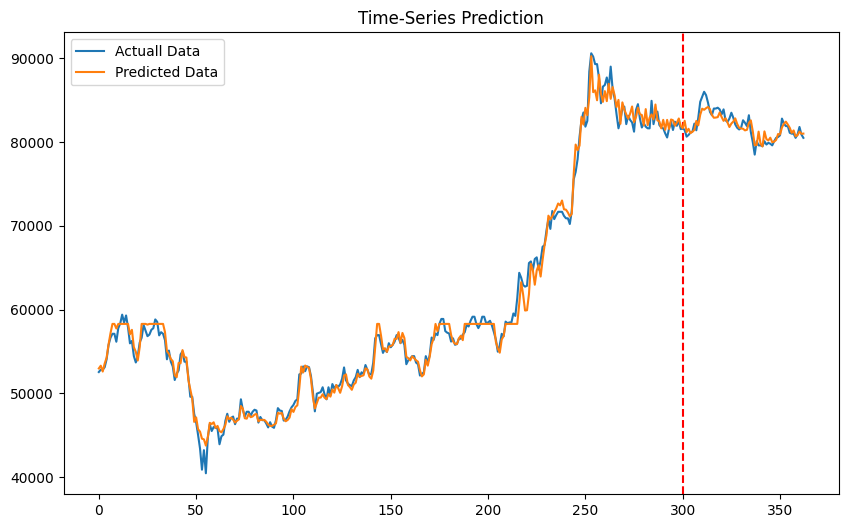

In [131]:
train_predict = lstm_fr(train.to(device))
data_predict = train_predict.data.detach().cpu().numpy()
dataY_plot = label.data.numpy()

data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6))
plt.axvline(x=300, c='r', linestyle='--')

plt.plot(dataY_plot, label='Actuall Data')
plt.plot(data_predict, label='Predicted Data')
plt.title('Time-Series Prediction')

plt.legend()
plt.show()